# 압축 풀기 (초기 1회)

In [22]:
import zipfile
import os

def extract_zip(zip_path, extract_to='.'):
    """
    zip_path: 압축 파일 경로
    extract_to: 압축 해제할 폴더 경로 (기본값은 현재 폴더)
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"{zip_path} 압축 해제 완료!")

# 압축 파일 경로와 압축 해제 경로 설정
zip_file_path = 'Validation.zip'
extract_folder = '.'

# 압축 해제
extract_zip(zip_file_path, extract_folder)


Validation.zip 압축 해제 완료!


In [1]:
c.FileContentsManager.delete_to_trash = True

NameError: name 'c' is not defined

# 전처리 

In [1]:

!pip install torch torchvision pillow matplotlib numpy scikit-learn gudhi
print("설치 완료.")

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
설치 완료.


In [24]:
import json

def parse_json_label(json_file):
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)


    label = {
        'filename': data['filename'],
        'label': data['label']
    }
    return label


In [26]:
import os

def get_image_paths_and_labels(image_folder, label_folder):
    image_paths = []
    labels = []


    image_dict = {}

    print("이미지 폴더 탐색 시작.")
    for root, _, files in os.walk(image_folder):
        for file in files:
            if file.endswith((".jpg", ".jpeg", ".png")):
                file_name_without_ext = os.path.splitext(file)[0]
                image_path = os.path.join(root, file)
                image_dict[file_name_without_ext] = image_path
                print(f"{image_path} 추가 완료.")
    print("이미지 폴더 탐색 완료.")

    print("라벨 폴더 탐색 시작.")
    for root, _, files in os.walk(label_folder):
        for file in files:
            if file.endswith(".json"):
                file_name_without_ext = os.path.splitext(file)[0]
                json_path = os.path.join(root, file)


                if file_name_without_ext in image_dict:
                    image_paths.append(image_dict[file_name_without_ext])
                    label = parse_json_label(json_path)
                    labels.append(label)
                    print(f"{json_path} 파싱 완료.")
                else:
                    print(f"경고: {file_name_without_ext}.png에 해당하는 JSON 파일을 찾을 수 없습니다.")

    return image_paths, labels


In [27]:
import torch
import torchvision.transforms as transforms
from PIL import Image

def preprocess_image(image_path):
    print(f"Processing image: {image_path}")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  # 그레이스케일 이미지 정규화
    ])

    image = Image.open(image_path).convert("L")
    return transform(image)

def preprocess_images(image_paths):
    processed_images = []
    for image_path in image_paths:
        processed_image = preprocess_image(image_path)
        processed_images.append(processed_image)
    return processed_images


In [28]:
def preprocess_labels(label_data):
    processed_labels = []

    class_dict = {
        'Normal': 0,
        'Abnormal': 1
    }

    for label in label_data:
        class_name = label['label']
        class_index = class_dict.get(class_name, -1)  # 없는 클래스는 -1로 처리

        if class_index != -1:
            processed_labels.append(torch.tensor(class_index, dtype=torch.long))

    return processed_labels


In [29]:
def save_preprocessed_labels_and_images(images, labels, image_save_path='processed_images.pt', label_save_path='processed_labels.pt'):
    torch.save(images, image_save_path)
    torch.save(labels, label_save_path)
    print(f"전처리된 이미지가 {image_save_path}에 저장되었습니다.")
    print(f"전처리된 라벨이 {label_save_path}에 저장되었습니다.")


In [ ]:
image_folder = 'Validation/01.원본데이터'
label_folder = 'Validation/02.라벨링데이터'


valid_image_paths, valid_labels = get_image_paths_and_labels(image_folder, label_folder)


processed_images = preprocess_images(valid_image_paths)
processed_labels = preprocess_labels(valid_labels)


save_preprocessed_labels_and_images(processed_images, processed_labels)
print("끝.")

In [ ]:
image_folder = 'Training/01.원본데이터'
label_folder = 'Training/02.라벨링데이터'

# 이미지와 라벨
train_image_paths, train_labels = get_image_paths_and_labels(image_folder, label_folder)

# 전처리
processed_images = preprocess_images(train_image_paths)
processed_labels = preprocess_labels(train_labels)

# 저장
save_preprocessed_labels_and_images(processed_images, processed_labels)
print("끝.")

In [ ]:
processed_images

# TDA 특징 추출 

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import gudhi as gd

# MRI 이미지 및 라벨 데이터 로드
processed_images = torch.load('train_processed_images.pt')
processed_labels = torch.load('train_processed_labels.pt')

# Normal과 Abnormal 이미지 분리
normal_images = [img.flatten().numpy() for img, label in zip(processed_images, processed_labels) if label.item() == 0]  # 0: Normal
abnormal_images = [img.flatten().numpy() for img, label in zip(processed_images, processed_labels) if label.item() == 1]  # 1: Abnormal

# Persistence Entropy 계산
def compute_persistence_entropy(diagram):
    lifetimes = [death - birth for birth, death in diagram if death != float('inf')]
    lifetimes = np.array(lifetimes)
    normalized_lifetimes = lifetimes / np.sum(lifetimes)
    entropy = -np.sum(normalized_lifetimes * np.log(normalized_lifetimes + 1e-10))  # NaN 방지
    return entropy

# Persistence Diagram과 Entropy 계산
def analyze_topology(data, title):
    # PCA로 차원 축소
    pca = PCA(n_components=2)
    data_reduced = pca.fit_transform(data)
    

    alpha_complex = gd.AlphaComplex(points=data_reduced)
    simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=10.0)  # alpha 값 조정
    

    diag = simplex_tree.persistence()
    

    gd.plot_persistence_diagram(diag)
    plt.title(f"Persistence Diagram: {title}")
    plt.show()

    h1_diagram = [(birth, death) for dim, (birth, death) in diag if dim == 1 and death != float('inf')]
    h1_entropy = compute_persistence_entropy(h1_diagram)
    print(f"Persistence Entropy (H1) for {title}:", h1_entropy)
    
    h0_diagram = [(birth, death) for dim, (birth, death) in diag if dim == 0 and death != float('inf')]
    h0_entropy = compute_persistence_entropy(h0_diagram)
    print(f"Persistence Entropy (H0) for {title}:", h0_entropy)

analyze_topology(normal_images, "Normal")
analyze_topology(abnormal_images, "Abnormal")


/tmp/ipykernel_77/3076922172.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  processed_images = torch.load('train_processed_images.pt')
/tmp/ipykernel_77/3076922172.py:

Persistence Entropy (H0) for Normal: 7.316900268606845
Persistence Entropy (H0) for Abnormal: 7.630469350835728
Persistence Entropy (H1) for Normal: 6.580749137774293
Persistence Entropy (H1) for Abnormal: 6.879493758290522


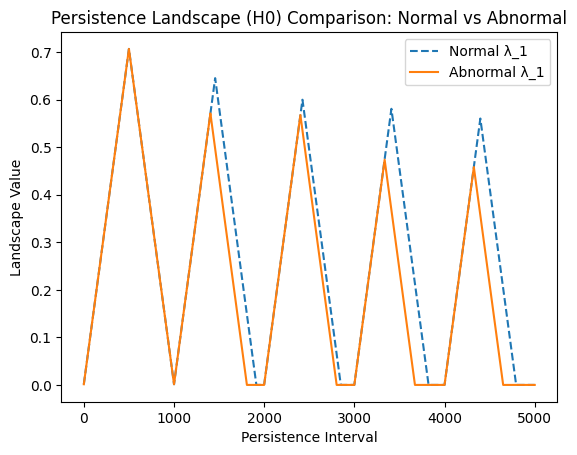

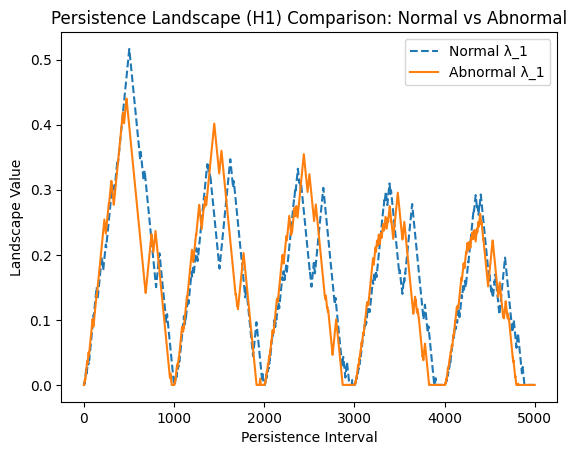

In [10]:
from sklearn.preprocessing import MinMaxScaler
import gudhi.representations as gd_rep
from gudhi.representations.preprocessing import DiagramScaler
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import gudhi as gd

processed_images = torch.load('train_processed_images.pt')
processed_labels = torch.load('train_processed_labels.pt')

normal_images = [img.flatten().numpy() for img, label in zip(processed_images, processed_labels) if label.item() == 0]  # 0: Normal
abnormal_images = [img.flatten().numpy() for img, label in zip(processed_images, processed_labels) if label.item() == 1]  # 1: Abnormal

def compute_persistence_entropy(diagram):
    lifetimes = [death - birth for birth, death in diagram if death != float('inf')]
    lifetimes = np.array(lifetimes)
    normalized_lifetimes = lifetimes / np.sum(lifetimes)
    entropy = -np.sum(normalized_lifetimes * np.log(normalized_lifetimes + 1e-10))  # NaN 방지
    return entropy


def analyze_topology_with_landscape(normal_data, abnormal_data, title):

    pca = PCA(n_components=2)
    normal_data_reduced = pca.fit_transform(normal_data)
    abnormal_data_reduced = pca.fit_transform(abnormal_data)
    

    def get_persistence_diagrams(data):
        alpha_complex = gd.AlphaComplex(points=data)
        simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=10.0)  # alpha 값 조정
        diag = simplex_tree.persistence()
        h0_diagram = np.array([(birth, death) for dim, (birth, death) in diag if dim == 0 and death != float('inf')])
        h1_diagram = np.array([(birth, death) for dim, (birth, death) in diag if dim == 1 and death != float('inf')])
        return h0_diagram, h1_diagram

    normal_h0, normal_h1 = get_persistence_diagrams(normal_data_reduced)
    abnormal_h0, abnormal_h1 = get_persistence_diagrams(abnormal_data_reduced)


    print(f"Persistence Entropy (H0) for Normal: {compute_persistence_entropy(normal_h0)}")
    print(f"Persistence Entropy (H0) for Abnormal: {compute_persistence_entropy(abnormal_h0)}")
    print(f"Persistence Entropy (H1) for Normal: {compute_persistence_entropy(normal_h1)}")
    print(f"Persistence Entropy (H1) for Abnormal: {compute_persistence_entropy(abnormal_h1)}")
    

    landscapes = gd_rep.Landscape(num_landscapes=5, resolution=1000)
    scaler = DiagramScaler(use=True, scalers=[([0], MinMaxScaler()), ([1], MinMaxScaler())])

    normal_h0_scaled = scaler.fit_transform([normal_h0])
    abnormal_h0_scaled = scaler.fit_transform([abnormal_h0])
    normal_h0_landscape = landscapes.fit_transform(normal_h0_scaled)
    abnormal_h0_landscape = landscapes.fit_transform(abnormal_h0_scaled)

    plt.figure()
    for i in range(min(5, normal_h0_landscape.shape[0])):
        plt.plot(normal_h0_landscape[i, :], label=f'Normal λ_{i+1}', linestyle='--')
        plt.plot(abnormal_h0_landscape[i, :], label=f'Abnormal λ_{i+1}', linestyle='-')
    plt.title(f"Persistence Landscape (H0) Comparison: {title}")
    plt.xlabel("Persistence Interval")
    plt.ylabel("Landscape Value")
    plt.legend()
    plt.show()


    normal_h1_scaled = scaler.fit_transform([normal_h1])
    abnormal_h1_scaled = scaler.fit_transform([abnormal_h1])
    normal_h1_landscape = landscapes.fit_transform(normal_h1_scaled)
    abnormal_h1_landscape = landscapes.fit_transform(abnormal_h1_scaled)

    plt.figure()
    for i in range(min(5, normal_h1_landscape.shape[0])):
        plt.plot(normal_h1_landscape[i, :], label=f'Normal λ_{i+1}', linestyle='--')
        plt.plot(abnormal_h1_landscape[i, :], label=f'Abnormal λ_{i+1}', linestyle='-')
    plt.title(f"Persistence Landscape (H1) Comparison: {title}")
    plt.xlabel("Persistence Interval")
    plt.ylabel("Landscape Value")
    plt.legend()
    plt.show()


analyze_topology_with_landscape(normal_images, abnormal_images, "Normal vs Abnormal")


# Mini data

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# GPU 설정 (GPU가 없으면 자동으로 CPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로드
processed_images = torch.load('train_processed_images.pt')
processed_labels = torch.load('train_processed_labels.pt')
valid_images = torch.load('valid_processed_images.pt')
valid_labels = torch.load('valid_processed_labels.pt')

# 만약 `processed_images`와 `processed_labels`가 리스트 형태라면, 텐서로 변환
processed_images = torch.stack([torch.tensor(img) for img in processed_images]).to(device)
processed_labels = torch.tensor(processed_labels).to(device)
valid_images = torch.stack([torch.tensor(img) for img in valid_images]).to(device)
valid_labels = torch.tensor(valid_labels).to(device)

# 학습 데이터에서 800개를 랜덤하게 샘플링
train_dataset = TensorDataset(processed_images, processed_labels)
train_sampled, _ = random_split(train_dataset, [2000, len(train_dataset) - 2000])

# 검증 데이터에서 100개를 랜덤하게 샘플링
valid_dataset = TensorDataset(valid_images, valid_labels)
valid_sampled, _ = random_split(valid_dataset, [500, len(valid_dataset) - 500])

# 샘플링된 데이터를 추출하여 저장
# 학습 데이터 저장
train_images_sampled = torch.stack([img for img, _ in train_sampled])
train_labels_sampled = torch.tensor([label for _, label in train_sampled])
torch.save(train_images_sampled, 'train_2000_images.pt')
torch.save(train_labels_sampled, 'train_2000_labels.pt')

# 검증 데이터 저장
valid_images_sampled = torch.stack([img for img, _ in valid_sampled])
valid_labels_sampled = torch.tensor([label for _, label in valid_sampled])
torch.save(valid_images_sampled, 'valid_500_images.pt')
torch.save(valid_labels_sampled, 'valid_500_labels.pt')

print("샘플링된 학습 및 검증 데이터가 저장되었습니다.")


/tmp/ipykernel_84/1572532542.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  processed_images = torch.load('train_processed_images.pt')
/tmp/ipykernel_84/1572532542.py:9

샘플링된 학습 및 검증 데이터가 저장되었습니다.
